In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

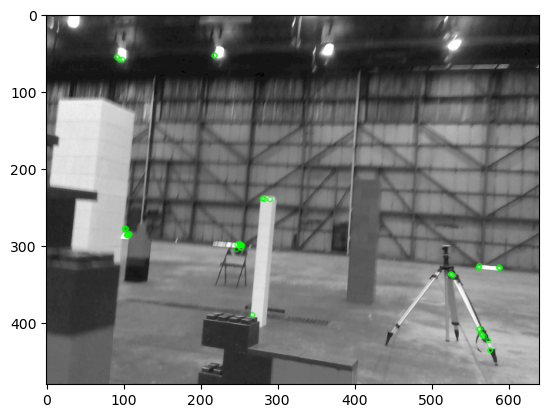

(<matplotlib.image.AxesImage at 0x7feccca0a940>, None)

In [2]:
img0 = cv.imread('DEPTH_IMAGE0.PNG', cv.IMREAD_GRAYSCALE)
img1 = cv.imread('DEPTH_IMAGE1.PNG', cv.IMREAD_GRAYSCALE)
# Initiate ORB detector
orb = cv.ORB_create(nfeatures=50)


kp0, des0 = orb.detectAndCompute(img0,None)
kp1, des1 = orb.detectAndCompute(img1,None)

# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img0, kp0, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

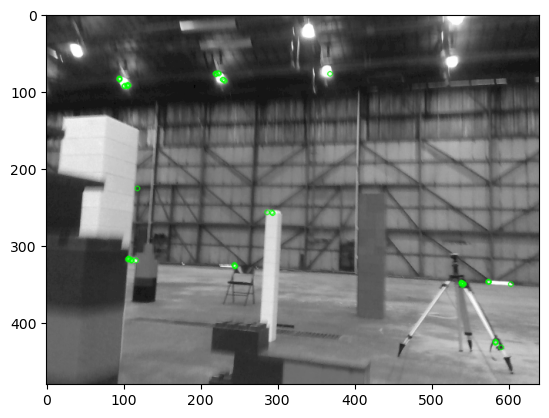

(<matplotlib.image.AxesImage at 0x7fecc6105a30>, None)

In [3]:
img3 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img3), plt.show()

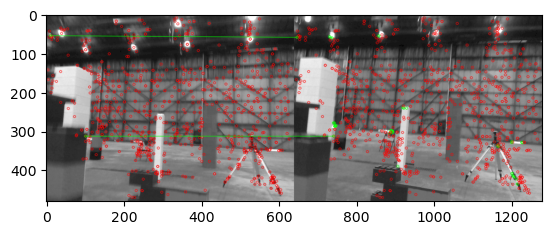

(<matplotlib.image.AxesImage at 0x7f12581edf10>, None)

In [23]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(np.float32(des0),np.float32(des1),k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [21]:
matchesMask

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [8]:
img0 = cv.imread('DEPTH_IMAGE0.PNG', cv.IMREAD_GRAYSCALE)
img1 = cv.imread('DEPTH_IMAGE1.PNG', cv.IMREAD_GRAYSCALE)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp0, des0_sift = sift.detectAndCompute(img0,None)
kp1, des1_sift = sift.detectAndCompute(img1,None)

In [9]:
des0_sift

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [13., 46.,  8., ...,  2.,  0.,  0.],
       ...,
       [ 0.,  1., 14., ...,  0.,  0.,  1.],
       [ 3.,  0.,  0., ..., 45.,  5., 26.],
       [13.,  1.,  5., ...,  0.,  0., 12.]], dtype=float32)

In [11]:
np.all(des0 == des0_sift)
np.all(des1 == des1_sift)

/tmp/ipykernel_39448/3233248375.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.all(des0 == des0_sift)
/tmp/ipykernel_39448/3233248375.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.all(des1 == des1_sift)


False

In [17]:
des0.shape

(50, 32)

In [18]:
des0_sift.shape

(814, 128)